# Visualizations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict, Counter

import psycopg2

from helper import percentile_rank

plt.style.use('dark_background')

In [2]:
features_df = pd.read_parquet('ProcessedData/features.parquet.gzip')
metrics_df = pd.read_parquet('ProcessedData/metrics.parquet.gzip')
metadata_df = pd.read_parquet('ProcessedData/metadata.parquet.gzip')

In [3]:
data = features_df.join(metrics_df).join(metadata_df)

In [4]:
loglikes_by_section = defaultdict(list)

for _, row in data.iterrows():
    if row['metadata_section'] is not None:
        loglikes_by_section[row['metadata_section']].append(row['log_likes'])

In [5]:
top_sections = sorted([(k, np.median(np.array(v)), len(v)) for k, v in loglikes_by_section.items() if len(v) > 50], key = lambda x: -x[1])
top_sections, _, _ = zip(*top_sections)

In [6]:
filtered_data = data[data['metadata_section'].isin(top_sections)].copy()

In [7]:
filtered_data['like_bins'] = pd.cut(np.round(10**filtered_data['log_likes'] - 1), [0,100,200,500,1000,200000])

In [8]:
likeBinsGroup = filtered_data.groupby(['metadata_section', 'like_bins']).size().unstack()
likeBinsProp = likeBinsGroup.div(likeBinsGroup.sum(axis = 1), axis = 0)
likeBinsProp = likeBinsProp.loc[top_sections[::-1], :]

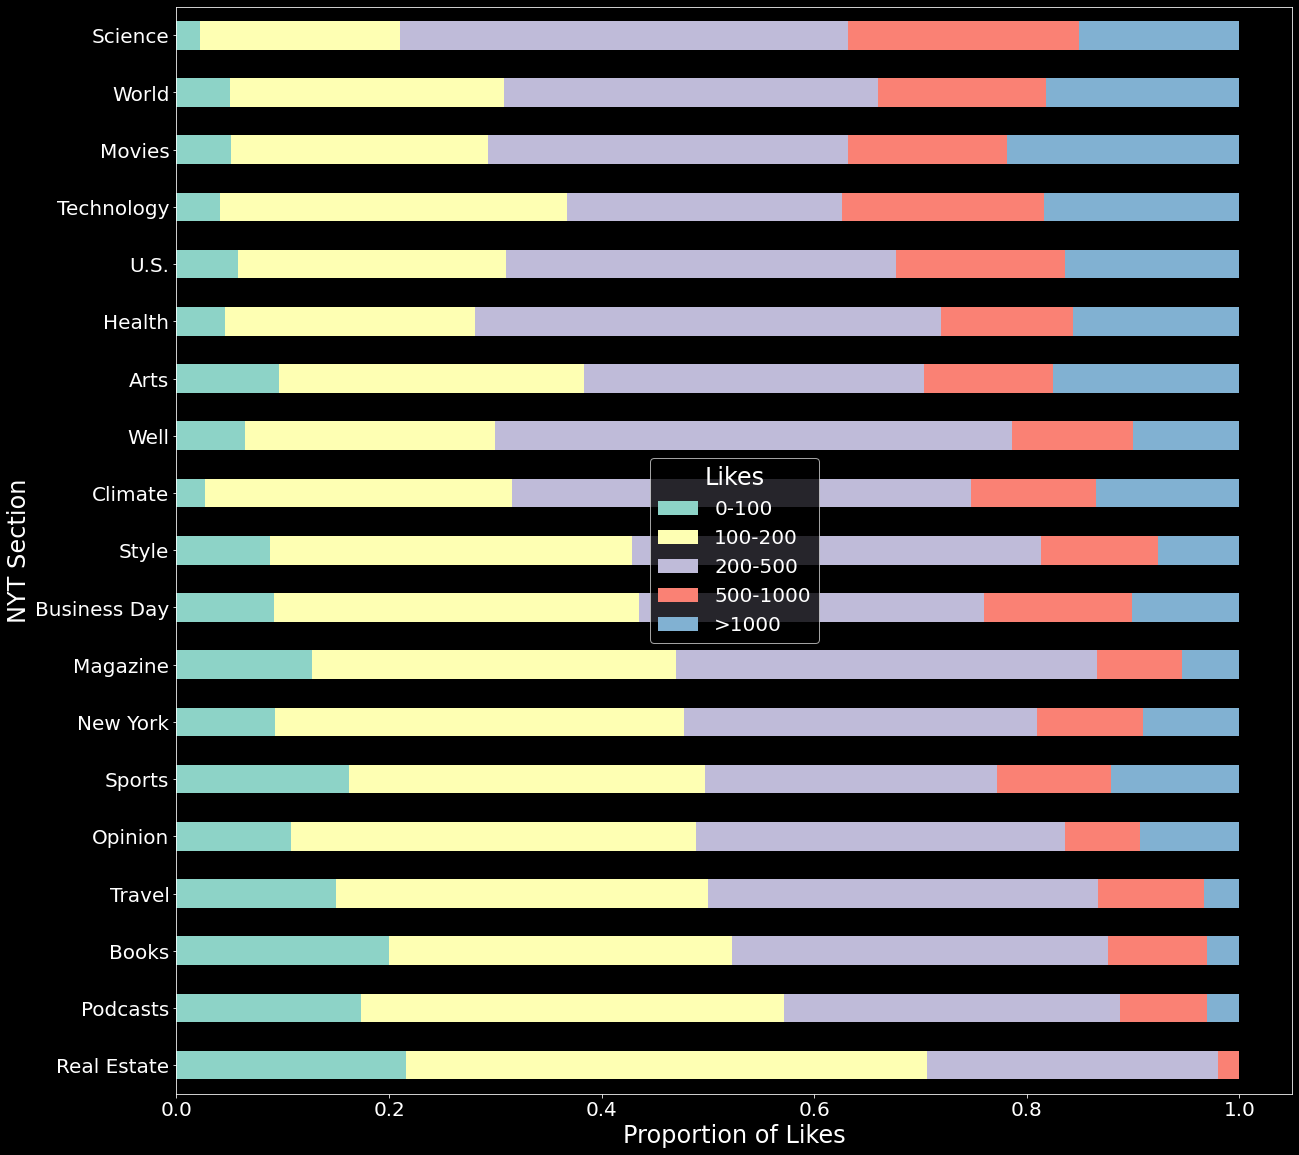

In [9]:
fig = plt.figure(figsize = (20, 20))
ax = fig.subplots(1)
likeBinsProp.plot(kind = 'barh', stacked = True, ax = ax)
ax.set_xlabel('Proportion of Likes', fontsize = 24)
ax.set_ylabel('NYT Section', fontsize = 24)
ax.tick_params(axis="y", labelsize=20)
ax.tick_params(axis="x", labelsize=20)
ax.legend(['0-100', '100-200', '200-500', '500-1000', '>1000'], title = 'Likes', title_fontsize = 24, fontsize = 20);

In [10]:
loglikes_by_keyword = defaultdict(list)

for _, row in data.iterrows():
    if row['metadata_keywords'] is not None:
        keywords = row['metadata_keywords'].split('|')
        for word in keywords:
            loglikes_by_keyword[word].append(row['log_likes'])

In [11]:
# sorted([(k, np.median(np.array(v)), len(v)) for k, v in loglikes_by_keyword.items()], key = lambda x: -x[2])

In [12]:
loglikes_by_topic = defaultdict(list)
keywords_by_topic = defaultdict(Counter)

TOPIC_THRESHOLD = 0.2

for _, row in data.iterrows():
    for topic_index in range(130):
        topic_name = f'topic_{topic_index:03}'
        if row[topic_name] > TOPIC_THRESHOLD:
            loglikes_by_topic[topic_name].append(row['log_likes'])
            if row['metadata_keywords'] is not None:
                keywords = row['metadata_keywords'].split('|')
                keywords_by_topic[topic_name].update(keywords)

In [13]:
# sorted([(k, np.median(np.array(v)), len(v)) for k, v in loglikes_by_topic.items()], key = lambda x: -x[1])

In [14]:
# sorted([(k, v.most_common(5), len(loglikes_by_topic[k])) for k, v in keywords_by_topic.items()])

In [15]:
curated_topics = []

with open('ProcessedData/topic_keywords', 'rt') as f:
    for word in f:
        curated_topics.append(word.strip())

In [16]:
keyword_loglikes_df = pd.DataFrame([(k, loglike) for k, v in loglikes_by_keyword.items() for loglike in v], columns = ['keyword', 'log_likes'])
keyword_loglikes_df = keyword_loglikes_df[keyword_loglikes_df['keyword'].isin(curated_topics)]

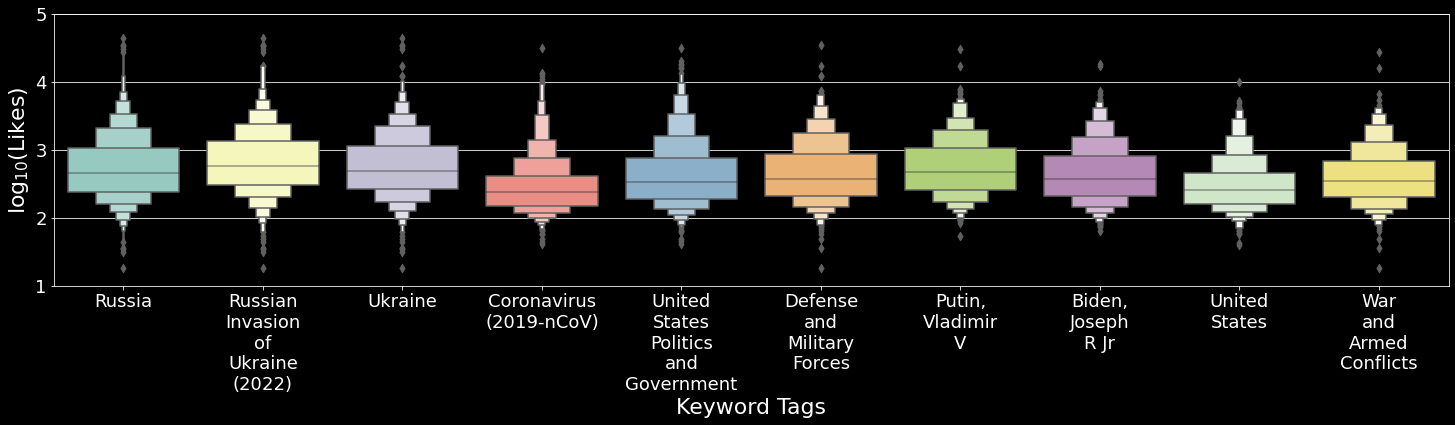

In [17]:
from matplotlib.ticker import MultipleLocator
import textwrap

order = curated_topics[:10]

fig, ax = plt.subplots(figsize = (25, 5))
ax.grid(zorder = 0)
ax.yaxis.set_major_locator(MultipleLocator(1))
boxen = sns.boxenplot(x = 'keyword', y = 'log_likes', data = keyword_loglikes_df, ax = ax, order = order)
ax.set_xticklabels([textwrap.fill(lab, 6, break_long_words = False) for lab in order])
plt.setp(boxen.collections, zorder = 10);
plt.setp(boxen.lines, zorder=11);
ax.set_ylim(1,5)
ax.set_xlabel('Keyword Tags', fontsize = 22)
ax.set_ylabel(r'$\log_{10}({\rm Likes})$', fontsize = 22)
ax.tick_params(axis="y", labelsize=18)
ax.tick_params(axis="x", labelsize=18)

In [18]:
# keyword_loglikes_df.to_parquet('ProcessedData/keyword_distributions.parquet.gzip', compression = 'gzip')

In [19]:
conn = psycopg2.connect(host = 'localhost', database = 'nytpopular')
with conn.cursor() as cursor:
    cursor.execute('''SELECT * FROM timeinfo;''')
    timedata = cursor.fetchall()
conn.close()

In [20]:
timedata_df = pd.DataFrame(timedata, columns = ['id', 'seconds', 'month', 'dayofweek']).set_index('id').join(data[['log_likes']])

In [21]:
for catvar in ['dayofweek', 'month']:
    timedata_df[catvar] = timedata_df[catvar].astype('category')

In [22]:
timedata_df['hour'] = timedata_df['seconds']//3600

In [23]:
# timedata_df['seconds'].to_frame().to_parquet('ProcessedData/seconds.parquet.gzip', compression = 'gzip')

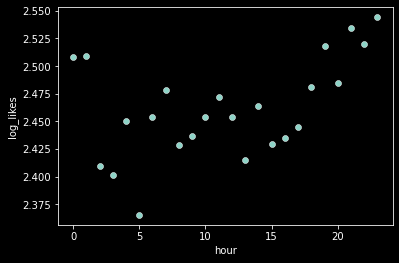

In [24]:
# Eastern Time

# sns.scatterplot(data = timedata_df.groupby(['hour']).agg('mean'), x = 'hour', y = 'log_likes')
sns.scatterplot(data = timedata_df.groupby('hour').agg('median'), x = 'hour', y = 'log_likes');

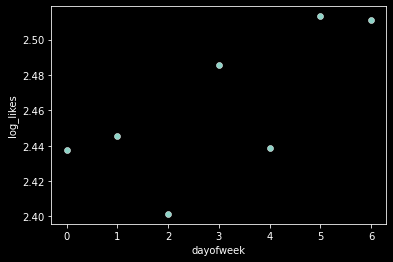

In [25]:
# 0 == Monday
# 6 == Sunday

sns.scatterplot(data = timedata_df.groupby('dayofweek').agg('median'), x = 'dayofweek', y = 'log_likes');

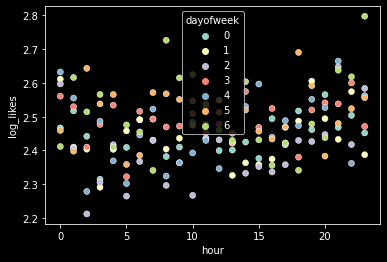

In [26]:
# timedata_df.plot(kind = 'scatter', x = 'seconds', y = 'log_likes', alpha = 0.1)
# sns.scatterplot(data = timedata_df, x = 'seconds', y = 'log_likes', alpha = 0.1, hue = 'dayofweek')
sns.scatterplot(data = timedata_df.groupby(['hour', 'dayofweek']).agg('median'), x = 'hour', y = 'log_likes', hue = 'dayofweek');

In [27]:
# timedata_df.groupby('dayofweek')['log_likes'].agg('median')
# data.groupby('tweet_has_video')['log_likes'].agg('median')
# data.groupby('tweet_has_photo')['log_likes'].agg('median')
# data.groupby('article_has_video')['log_likes'].agg('median')
# data.groupby('article_has_audio')['log_likes'].agg('median')

In [28]:
data['percentile'] = data['log_likes'].apply(lambda x: 100 * percentile_rank(x, data['log_likes']))
# data['quantile'] = pd.cut(data['percentile'], [0, 20, 40, 60, 80, 100])
data['Likes Percentile'] = pd.cut(data['percentile'], [0, 20, 40, 60, 80, 100]).cat.rename_categories(lambda x: f'{x.left} - {x.right}')

In [29]:
data = data.join(timedata_df['hour'])

In [30]:
# sns.histplot(data = data, hue = 'quantile', x = 'tweet_has_video', multiple = 'dodge', stat = 'probability')
# sns.histplot(data = data, x = 'percentile', hue = 'tweet_has_video', stat = 'probability')

In [31]:
def plot_conditional_proportions(column, xlabel = None, order = None, xticks = None, aspect = 1):
    with sns.plotting_context("notebook", font_scale = 1.5):
        facetgrid = (data
        .groupby(column)['Likes Percentile'].value_counts(normalize = True).rename('Conditional Proportion')
        .reset_index().rename(columns = {'level_1': 'Likes Percentile'})
        .pipe((sns.catplot, 'data'), kind = 'bar', hue = 'Likes Percentile', y = 'Conditional Proportion', x = column, order = order, height = 5, aspect = aspect, legend_out = True)
        )
        facetgrid.ax.set_ylabel('Relative Proportion')
        if xlabel is not None:
            facetgrid.ax.set_xlabel(xlabel)
        if xticks is not None:
            facetgrid.ax.set_xticklabels(xticks)
    return facetgrid

# def plot_conditional_proportions(column, xlabel = None, order = None, xticks = None, aspect = 1):
#     facetgrid = (data
#     .groupby(column)['Likes Percentile'].value_counts(normalize = True).rename('Conditional Proportion')
#     .reset_index().rename(columns = {'level_1': 'Likes Percentile'})
#     .pipe((sns.catplot, 'data'), kind = 'bar', hue = 'Likes Percentile', y = 'Conditional Proportion', x = column, order = order, height = 5, aspect = aspect, legend_out = True)
#     )
#     facetgrid.ax.set_ylabel('Relative Proportion', fontsize = 16)
#     if xlabel is not None:
#         facetgrid.ax.set_xlabel(xlabel, fontsize = 16)
#     if xticks is not None:
#         facetgrid.ax.set_xticklabels(xticks, fontsize = 15)
#     facetgrid.ax.yaxis.set_tick_params(labelsize = 12)
#     plt.setp(facetgrid._legend.get_title(), fontsize = 16)
#     facetgrid._legend.get_title().set_fontsize(16)
#     for text in facetgrid.legend.texts:
#         text.set_fontsize(15)
#     return facetgrid

# def plot_conditional_proportions(column):
#     ax = (data
#     .groupby(column)['Likes Percentile'].value_counts(normalize = True).rename('Conditional Proportion')
#     .reset_index().rename(columns = {'level_1': 'Likes Percentile'})
#     .pipe((sns.barplot, 'data'), hue = 'Likes Percentile', y = 'Conditional Proportion', x = column)
#     )
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     return ax

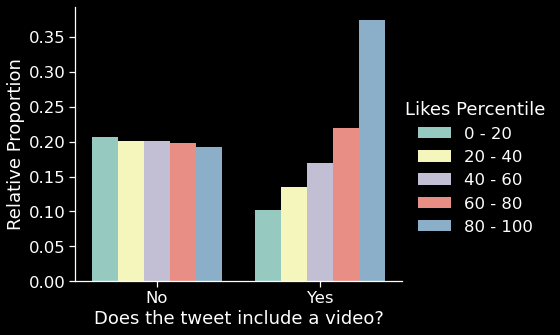

In [32]:
plot_conditional_proportions(
    'tweet_has_video',
    xlabel = 'Does the tweet include a video?',
    order = [0, 1],
    xticks = ['No', 'Yes'],
    aspect = 1.25
);

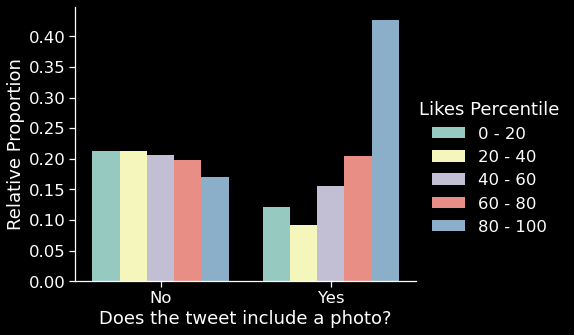

In [33]:
plot_conditional_proportions(
    'tweet_has_photo',
    xlabel = 'Does the tweet include a photo?',
    order = [0, 1],
    xticks = ['No', 'Yes'],
    aspect = 1.25
);

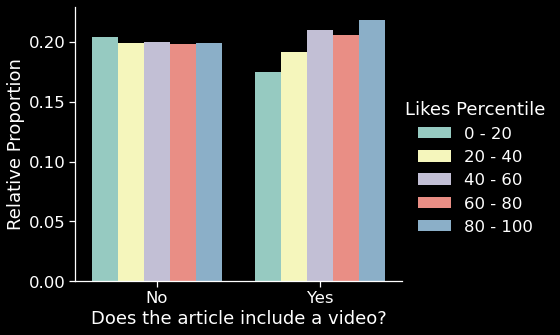

In [34]:
plot_conditional_proportions(
    'article_has_video',
    xlabel = 'Does the article include a video?',
    order = [0, 1],
    xticks = ['No', 'Yes'],
    aspect = 1.25
);

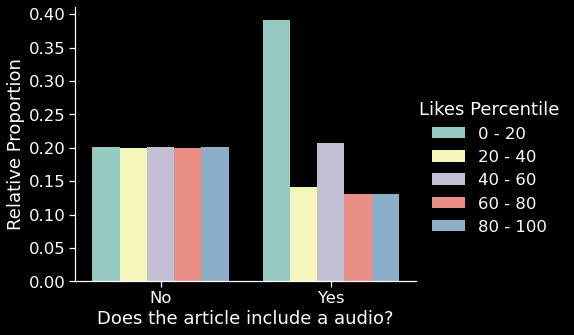

In [35]:
plot_conditional_proportions(
    'article_has_audio',
    xlabel = 'Does the article include a audio?',
    order = [0, 1],
    xticks = ['No', 'Yes'],
    aspect = 1.25
);

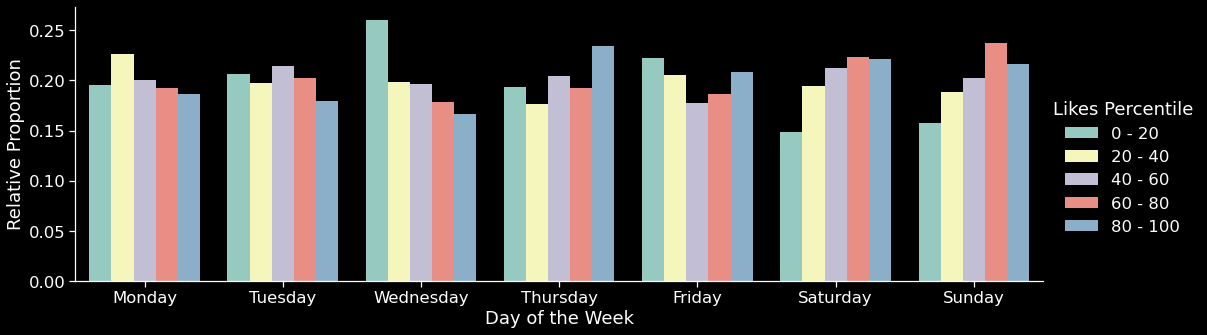

In [36]:
plot_conditional_proportions(
    'dayofweek',
    xlabel = 'Day of the Week',
    order = range(7),
    xticks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    aspect = 3
);

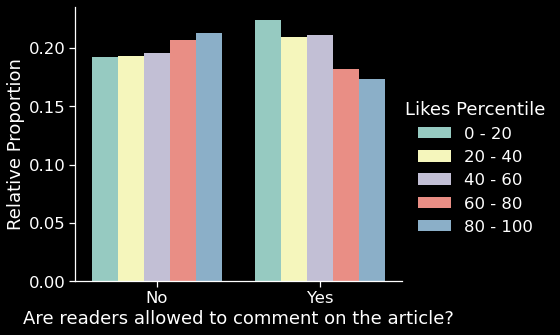

In [37]:
plot_conditional_proportions(
    'comments',
    xlabel = 'Are readers allowed to comment on the article?',
    order = [0, 1],
    xticks = ['No', 'Yes'],
    aspect = 1.25
);

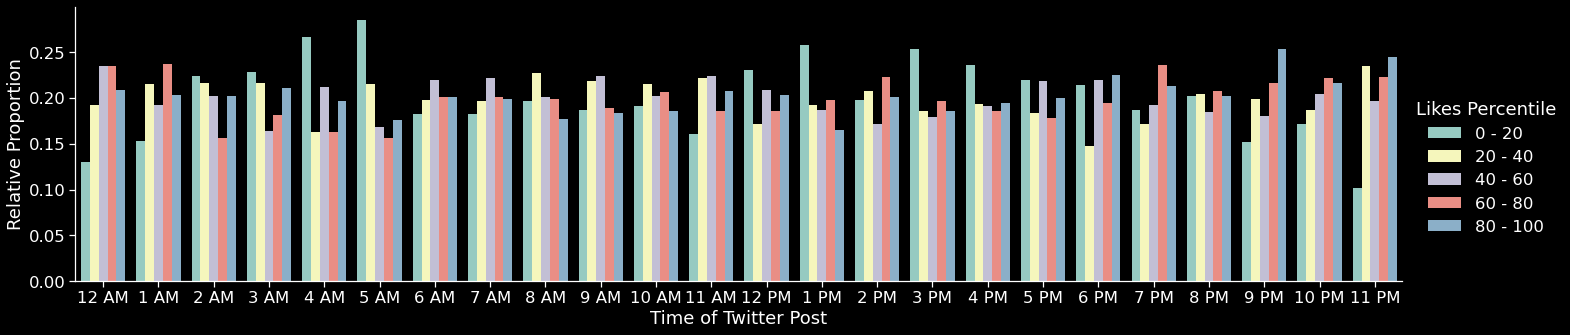

In [38]:
# plot_conditional_proportions('section')

plot_conditional_proportions(
    'hour',
    xlabel = 'Time of Twitter Post',
    order = range(24),
    xticks = ['12 AM'] + [f'{h} AM' for h in range(1, 12)] + ['12 PM'] + [f'{h} PM' for h in range(1, 12)],
    aspect = 4
);